In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

from scipy.stats import norm, landau
from scipy.optimize import curve_fit


SAVE_PLOTS = True
DARK_GREY='#393939'

In [2]:
file_path = r'data\muon_telescope\vp2ps_20250313-094335.csv'
df = pd.read_csv(file_path)
df['V'].describe()


count    88.000000
mean      6.836364
std       5.509327
min       0.800000
25%       5.500000
50%       6.800000
75%       8.000000
max      43.200001
Name: V, dtype: float64

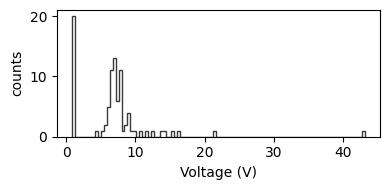

In [3]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.hist(df['V'], bins=100, color=DARK_GREY, histtype='step', linewidth=1)
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('counts')
plt.tight_layout()
plt.show()

## Initial data processing
Make cuts on data, change time into a legible format

In [4]:
V_low_cut = 3
V_high_cut = 20

df = df.loc[(df['V'] > V_low_cut) & (df['V'] < V_high_cut)]

min = df['V'].min()
max = df['V'].max()

df['t'] = [datetime.fromtimestamp(t) for t in df['t']]
df['t'] = pd.to_datetime(df['t'])
df = df.sort_values(by='t')


In [5]:

def print_stats():
    time_diff = (df['t'].iloc[-1] - df['t'].iloc[0]).seconds / 60
    avg_data_points_per_minute = df.shape[0] / time_diff

    print(f'Number of data points: {df.shape[0]}')
    print(f'Start time: {df["t"].iloc[0]}')
    print(f'End time: {df["t"].iloc[-1]}')
    print(f'Average number of data points per minute: {avg_data_points_per_minute:.2f}')
    print(f'Average number of data points per hour: {avg_data_points_per_minute * 60:.2f}')
    print(f'Total time of measurement: {time_diff // 60:.0f} hours and {time_diff % 60:.0f} minutes')
print_stats()

Number of data points: 66
Start time: 2025-03-13 09:43:37.729236
End time: 2025-03-13 17:15:11.866017
Average number of data points per minute: 0.15
Average number of data points per hour: 8.77
Total time of measurement: 7 hours and 32 minutes


# Fit Gaussian

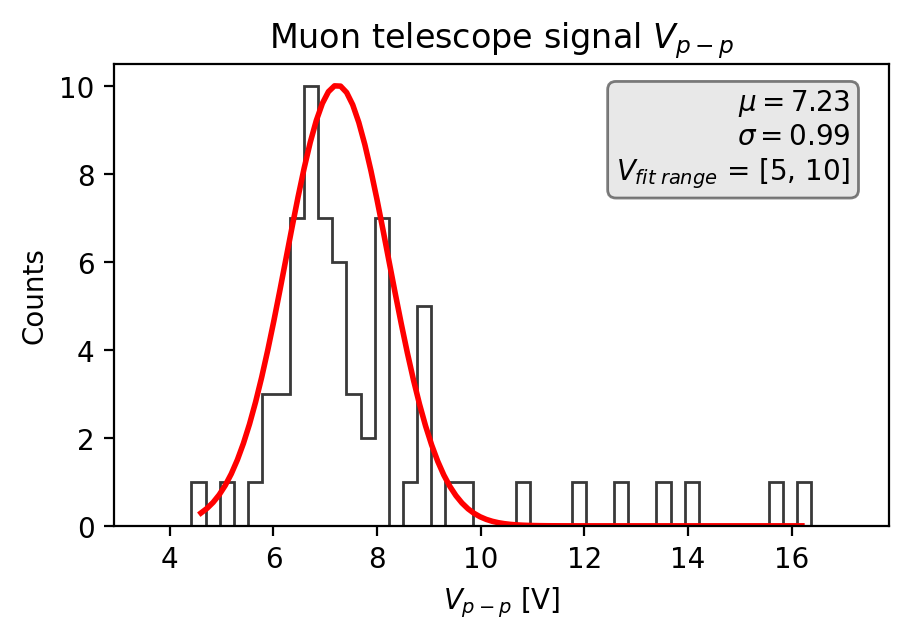

In [7]:
fig, ax = plt.subplots(1,1, figsize=(5, 3), dpi = 200)

count, bins, _ = ax.hist(df['V'], bins=50, range=(min - 1, max + 1), histtype='step', color=DARK_GREY, linewidth=1)


def fit_gauss(voltages, V_min = 4, V_max = 12):
    voltages = voltages.where(voltages < V_max)
    voltages = voltages.where(voltages > V_min)
    voltages = voltages.dropna()
    mu, sigma= norm.fit(voltages)  
    return mu, sigma

V_fit_min = 5
V_fit_max = 10
mu_fit, sigma_fit = fit_gauss(df['V'], V_fit_min, V_fit_max)

x = np.linspace(df['V'].min(), df['V'].max(), 100)
pdf = norm.pdf(x, mu_fit, sigma_fit)  
pdf *= count.max() / pdf.max()  
plt.plot(x, pdf, 'r', linewidth=2, label=f'Fit: $\mu$={mu_fit:.2f}, $\sigma$={sigma_fit:.2f}')

textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu_fit, ),
    r'$\sigma=%.2f$' % (sigma_fit, ),
    r'$V_{fit \; range}$ = [%d, %d]' % (V_fit_min, V_fit_max)
))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)
ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

ax.set_title(r'Muon telescope signal $V_{p-p}$')
ax.yaxis.get_major_locator().set_params(integer=True) # force integer ticks on y axis

ax.set_xlabel(r'$V_{p-p}$ [V]')
ax.set_ylabel('Counts')

if SAVE_PLOTS:
    plt.savefig('plots/muon_telescope/gauss_fit.jpg', dpi=300)
plt.show()

# Fit Landau

The muon energy is actually supposed to be in a landau distribution.

### Long-Form Landau Distribution

The Landau distribution for energy loss $x$ is given by:

$$
L(x; \mu, \eta) = \frac{1}{\eta} \cdot \int_0^\infty e^{-z} \left[ \sin \left( \frac{x - \mu}{\eta} + z \right) - \sin \left( \frac{x - \mu}{\eta} \right) \right] dz
$$

Where:
- $ x $ is the energy loss,
- $ \mu $ is the most probable value of the energy loss (mode of the distribution),
- $ \eta $ is the scale parameter, which controls the width of the distribution.


Number of valid data points: 66


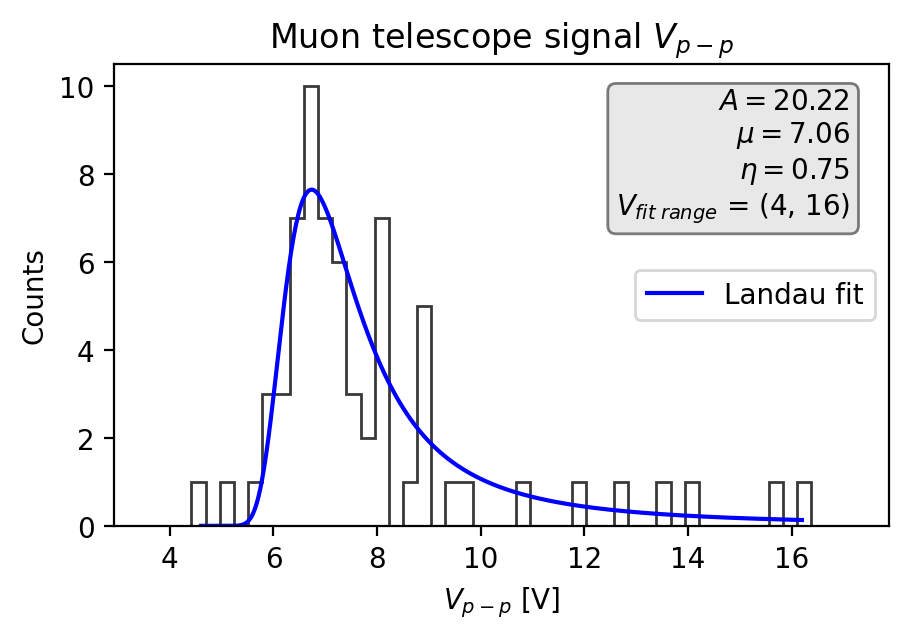

In [ ]:

fig, ax = plt.subplots(1,1, figsize=(5, 3), dpi = 200)
count, bins, _ = ax.hist(df['V'], bins=50, range=(min - 1, max + 1), histtype='step', color=DARK_GREY, linewidth=1)

bin_centers = (bins[:-1] + bins[1:]) / 2
bin_centers = bin_centers[count > 0]
count = count[count > 0]

V_fit_min = 4
V_fit_max = 16

count = count[bin_centers > V_fit_min]
bin_centers = bin_centers[bin_centers > V_fit_min]

count = count[bin_centers < V_fit_max]
bin_centers = bin_centers[bin_centers < V_fit_max]

A_guess = count.max()
mpv_guess = bin_centers[np.argmax(count)]
eta_guess = np.std(df['V'])

def landau_pdf(x, A, mu, eta):
    return A * landau.pdf(x, mu, eta)

popt, pcov = curve_fit(landau_pdf, bin_centers, count, p0=[A_guess, mpv_guess, eta_guess], maxfev=50000)
A_fit, mu_fit, eta_fit = popt


x_fit = np.linspace(df['V'].min(), df['V'].max(), 500)
y_fit = landau_pdf(x_fit, *popt)
plt.plot(x_fit, y_fit, linewidth=1.5, label=f'Landau fit', color = 'blue')

textstr = '\n'.join((
    r'$A=%.2f$' % (A_fit, ),
    r'$\mu=%.2f$' % (mu_fit, ),
    r'$\eta=%.2f$' % (eta_fit, ),
    r'$V_{fit \; range}$ = (%d, %d)' % (V_fit_min, V_fit_max)
))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)
ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

ax.set_title(r'Muon telescope signal $V_{p-p}$')
ax.yaxis.get_major_locator().set_params(integer=True)

ax.set_xlabel(r'$V_{p-p}$ [V]')
ax.set_ylabel('Counts')

plt.legend()

if SAVE_PLOTS:
    plt.savefig('plots/muon_telescope/landau_fit.jpg', dpi=300)
plt.show()